In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [2]:
import tensorflow_datasets as tfds

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.layers import Conv2D , MaxPool2D , Dense , InputLayer , Flatten , BatchNormalization  , Dropout
from tensorflow.keras.losses import MeanSquaredError , Huber , MeanAbsoluteError , BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy , FalsePositives , FalseNegatives, TruePositives , TrueNegatives, Precision, Recall , AUC, BinaryAccuracy
import sklearn
from sklearn.metrics import confusion_matrix , classification_report , roc_curve, auc
from tensorflow.keras.callbacks import Callback , EarlyStopping , ModelCheckpoint , ReduceLROnPlateau , CSVLogger , LearningRateScheduler
from tensorflow.keras.regularizers import L2 , L1
from tensorboard.plugins.hparams import api as hp

In [4]:
dataset , dataset_info = tfds.load('malaria' , with_info = True,  as_supervised = True , 
                                   shuffle_files = True , split = 'train[:60%]')

**DATA PREPARATION**

In [5]:
def splits(dataset , TRAIN_RATIO , VAL_RATIO , TEST_RATIO):
    DATASET_SIZE = tf.data.experimental.cardinality(dataset).numpy()

    #dataset = tf.data.Dataset.range(10)
    
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    #print(list(train_dataset.as_numpy_iterator()))
    
    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
    #print(list(val_dataset.as_numpy_iterator()))
    
    test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
    #print(list(test_dataset.as_numpy_iterator()))
    
    return train_dataset , val_dataset , test_dataset
    
    

In [6]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset , val_dataset , test_dataset = splits(dataset, TRAIN_RATIO , VAL_RATIO , TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()) ,
      list(val_dataset.take(1).as_numpy_iterator()) , 
      list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], shape=(103, 103, 3), dtype=uint8), np.int64(1))] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 

In [7]:
# #TRAIN_RATIO = 0.6
# #VAL_RATIO = 0.2
# #TEST_RATIO = 0.2

# # THIS CELL IS JUST FOR BETTER UNDERSTANDING

# dataset = tf.data.Dataset.range(10)
# #def splits(dataset , TRAIN_RATIO , VAL_RATIO , TEST_RATIO):
# DATASET_SIZE = len(dataset)
    
# train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
# print(list(train_dataset.as_numpy_iterator()))
    
# val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
# val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
# print(list(val_dataset.as_numpy_iterator()))
    
# test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
# print(list(test_dataset.as_numpy_iterator()))
 
    
    

In [8]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\asus\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved ma

In [10]:
for data in dataset.take(4):
    print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], shape=(103, 103, 3), dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(115, 157, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
     

In [11]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

**DATA VISUALIZATION**

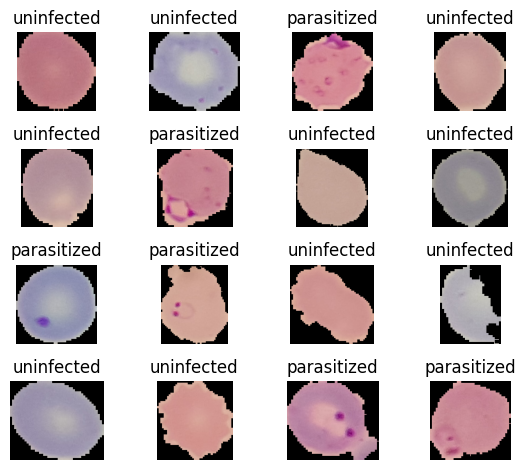

In [12]:
for i, (image , label) in enumerate(train_dataset.take(16).as_numpy_iterator()):
    ax = plt.subplot(4  , 4 , i+1)
    #plt.figure(figsize=(2,2))
    plt.imshow(image)
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis("off")
    plt.tight_layout()

    
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(4, 4, figsize=(8, 8))
# axes = axes.flatten()

# for i, (image, label) in enumerate(train_dataset.take(16).as_numpy_iterator()):
#     axes[i].imshow(image)
#     axes[i].set_title(dataset_info.features['label'].int2str(label))
#     axes[i].axis("off")

# plt.tight_layout()
# plt.show()




In [13]:
dataset_info.features["label"].int2str(1)
dataset_info.features["label"].int2str(0)

'parasitized'

**DATA PREPROCESSING**

In [14]:
IM_SIZE = 224
def resize_rescale(image , label):
    image = tf.image.resize(image , (IM_SIZE , IM_SIZE))
    image = tf.cast(image , tf.float32)/255.0
    return image , label

In [15]:
train_dataset = train_dataset.map(resize_rescale , num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(resize_rescale , num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resize_rescale , num_parallel_calls=tf.data.AUTOTUNE)
train_dataset
# val_dataset
# test_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [16]:
for image,label in train_dataset.take(1):
    print(image , label)


tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [17]:
for images, labels in train_dataset.take(1):
    print(images.shape)

(224, 224, 3)


In [18]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8 , reshuffle_each_iteration = True ).batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
val_dataset = val_dataset.shuffle(buffer_size = 8 , reshuffle_each_iteration = True ).batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
test_dataset = test_dataset.shuffle(buffer_size = 8 , reshuffle_each_iteration = True ).batch(32).prefetch(tf.data.AUTOTUNE)

In [21]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [22]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [23]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [24]:
for images, labels in train_dataset.take(1):
    print(images.shape)

(32, 224, 224, 3)


**DATA AUGMENTATION**

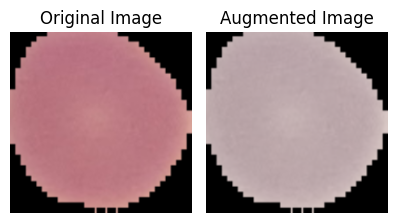

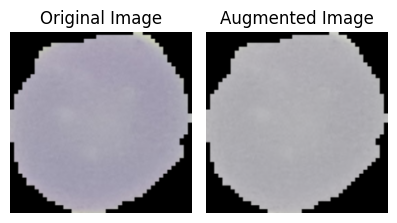

'parasitized'

In [25]:
for i, (image , label) in enumerate(train_dataset.take(2).as_numpy_iterator()):
    
    image = image[0]
    plt.figure(figsize=(8,8))
    
    plt.subplot(1 , 4 , 2*i + 1)
    plt.title("Original Image")
    plt.axis("off")
    plt.imshow(image)
    plt.tight_layout()
    
    
    plt.subplot(1 , 4, 2*i + 2)
    plt.imshow(tf.image.adjust_saturation(image , saturation_factor = 0.3).numpy())
    plt.title("Augmented Image")
    plt.axis("off")
    # plt.title(dataset_info.features["label"].int2str(label))
    # plt.axis("off")
    plt.tight_layout()
    
    plt.show()

dataset_info.features["label"].int2str(1)
dataset_info.features["label"].int2str(0)

**MODEL CREATION**

In [26]:
# SEQUENTIAL MODEL
IM_SIZE = 224
dropout_rate = 0.3
regularization_rate = 0.01

lenet_model = tf.keras.Sequential([
                            InputLayer(input_shape = (IM_SIZE , IM_SIZE , 3)),
                            
                            Conv2D(filters = 6 , kernel_size = 3 , strides = 1 , padding = "valid" , 
                                   kernel_regularizer = L2(0.01) , activation = "relu"),
                            BatchNormalization(),
                            MaxPool2D(pool_size= 2 , strides = 2),
                            Dropout(rate = dropout_rate),
                            
                            Conv2D(filters = 16 , kernel_size = 3 , strides = 1 , padding = "valid" , 
                                   kernel_regularizer = L2(0.01) , activation = "relu"),                                                      
                            BatchNormalization(),
                            MaxPool2D(pool_size= 2 , strides = 2),
                            
                            Flatten(),
                            
                            Dense(1000 , activation = "relu" , kernel_regularizer= L2(0.01)),
                            BatchNormalization(),
                            Dropout(rate = dropout_rate),
                            
                            Dense(100 , activation = "relu" , kernel_regularizer= L2(0.01)),
                            BatchNormalization(),

                            Dense(1 , activation = "sigmoid"),
                            
])
lenet_model.summary()

c:\Users\asus\Documents\dl_cv_tensorflow\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │    46,657,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,762,737 (178.39 MB)

 Trainable params: 46,760,493 (178.38 MB)

 Non-trainable params: 2,244 (8.77 KB)

In [27]:
# # CREATING FEATURE EXTRACTOR MODEL FROM SEQUENTIAL MODEL
# IM_SIZE = 224
# feature_extractor_seq_model = tf.keras.Sequential([
#                             InputLayer(input_shape = (IM_SIZE , IM_SIZE , 3)),
                            
#                             Conv2D(filters = 6 , kernel_size = 3 , strides = 1 , padding = "valid" , 
#                                    activation = "relu"),
#                             BatchNormalization(),
#                             MaxPool2D(pool_size= 2 , strides = 2),
                            
#                             Conv2D(filters = 16 , kernel_size = 3 , strides = 1 , padding = "valid" , 
#                                    activation = "relu"),                                                      
#                             BatchNormalization(),
#                             MaxPool2D(pool_size= 2 , strides = 2),

# ])
# feature_extractor_seq_model.summary()

In [28]:
y_true = [0 , 1 , 0 , 0]
y_pred = [0.6 , 0.51 , 0.94 , 1]
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true , y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=5.086357593536377>

In [29]:
#from tensorflow.keras.losses import SparseCategoricalCrossentropy

lenet_model.compile(optimizer = Adam(learning_rate = 0.01),
            loss = BinaryCrossentropy(), metrics=["accuracy"])

In [30]:
tf.config.run_functions_eagerly(True)

In [31]:
history = lenet_model.fit(train_dataset , validation_data = val_dataset , epochs = 1 , verbose = 1)

414/414 ━━━━━━━━━━━━━━━━━━━━ 420s 1s/step - accuracy: 0.6205 - loss: 32.0752 - val_accuracy: 0.5166 - val_loss: 6.5030


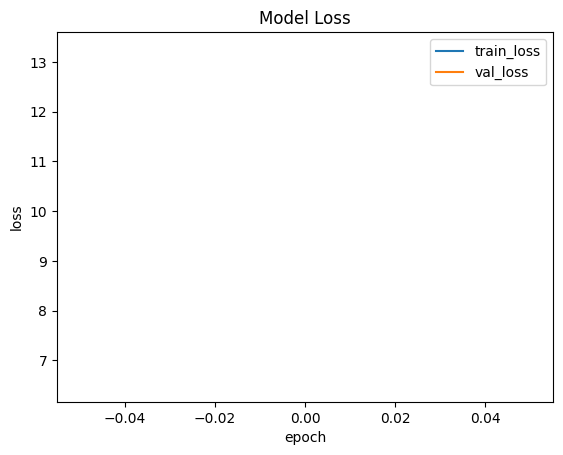

In [32]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss" , "val_loss"])
plt.show()

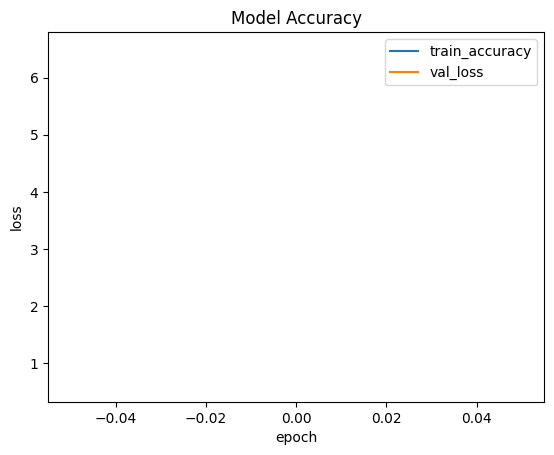

In [33]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_loss"])
plt.title("Model Accuracy")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_accuracy" , "val_loss"])
plt.show()

In [34]:
lenet_model.predict(train_dataset.take(1)).shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


(32, 1)

**MODEL EVALUATION AND TESTING**

In [35]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [36]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [37]:
lenet_model.evaluate(test_dataset)

52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.4929 - loss: 6.5475


[6.537125110626221, 0.5]

In [38]:
#lenet_model.evaluate(train_dataset)

In [39]:
lenet_model.predict(test_dataset.take(1))[0]  #it is just prediction of any row and column

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


array([0.22845922], dtype=float32)

In [40]:
lenet_model.predict(train_dataset.take(1))[0]   # similarly it is also just prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


array([0.20125693], dtype=float32)

In [41]:
def parasite_or_not(x):
    if(x < 0.5):
        return str('P')
    else:
        return str('U')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


c:\Users\asus\Documents\dl_cv_tensorflow\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


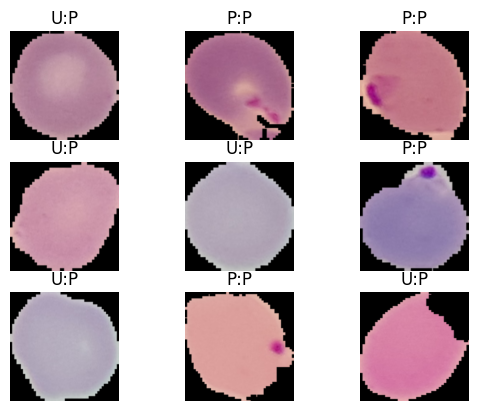

In [42]:
for i,(image , label) in enumerate(test_dataset.take(9)):
    
    ax = plt.subplot(3 , 3 , i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":"  + str(parasite_or_not(lenet_model.predict(image)[0][0])))
    
    plt.axis("off")

# Evaluating Classification Models [Malaria Diagnosis]

**PRECISION, RECALL and ACCURACY**
> Precision =  TP/TP + FP

> Recall = TP / TP + FN

> Accuracy = TN + TP / TP + TN + FN+ FP

> F1 - Score = 2PR / P+R

> Specificity = TN / TN + FP

In [43]:
metrics = [TruePositives(name = "TP") ,
           TrueNegatives(name = "TN") , FalsePositives(name = "FP") ,
           FalseNegatives(name = "FN") , Precision(name = "Precision") ,
           Recall(name = "Recall") , AUC(name = "AUC") , BinaryAccuracy(name = "Accuracy")]

In [44]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01) , loss = "binary_crossentropy" ,
                        metrics = metrics)

In [45]:
#history  = lenet_model.fit(train_dataset , validation_data = val_dataset , epochs = 1 , verbose = 1)   

**Visualizing Confusion Matrix**

In [46]:
labels = []
inp = []

for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)   

In [47]:
labels = np.array([i[0] for i in labels])
print(labels)
print(len(labels))


[0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0
 0 1 0 0 1 1 0 0 1 1 1 1 1 0 1]
52


In [48]:
inp = [np.random.rand(224, 224, 3) for _ in range(len(test_dataset))]
arr = np.stack(inp)
print(arr.shape)            # (2757, 224, 224, 3)
print(arr[:, 0, ...].shape) # (2757, 224, 3)


(52, 224, 224, 3)
(52, 224, 3)


In [49]:
predicted = lenet_model.predict(arr)
print(predicted[:,0])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
[0.5285495  0.53710043 0.52711016 0.5553409  0.52941287 0.53417856
 0.5294556  0.5124081  0.53439474 0.53022796 0.5352471  0.53135026
 0.53550655 0.54147094 0.5314196  0.5105185  0.5194078  0.5261745
 0.52457666 0.51900655 0.5243035  0.5385932  0.51924413 0.5153323
 0.5395301  0.5207447  0.5292846  0.5543276  0.54473287 0.5137955
 0.53556436 0.5327376  0.52923596 0.5281345  0.5300987  0.5240522
 0.5200672  0.5371129  0.52994543 0.53022456 0.52952003 0.543763
 0.5311254  0.5371996  0.5301803  0.5167039  0.5341329  0.5204214
 0.5244471  0.534693   0.5371613  0.5264534 ]


In [50]:
print("Labels shape:", np.array(labels).shape)
print("Predicted shape:", np.array(predicted).shape)


Labels shape: (52,)
Predicted shape: (52, 1)


[[ 0 26]
 [ 0 26]]


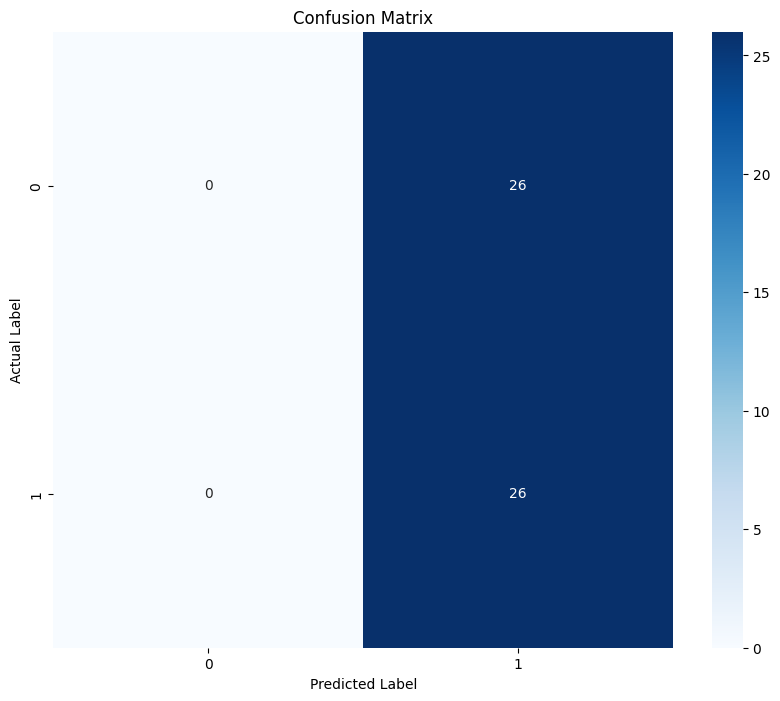

In [51]:
threshold = 0.25
cm = confusion_matrix(labels , predicted > threshold)
print(cm)


plt.figure(figsize=(10, 8))
sns.heatmap(cm , annot = True , fmt = "d" , cmap = "Blues" )
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")   
plt.title("Confusion Matrix")
plt.show()


**ROC PLOTS**

In [52]:
fp, tp , thresholds = roc_curve(labels , predicted)

In [53]:
print(len(fp), len(tp), len(thresholds))

29 29 29


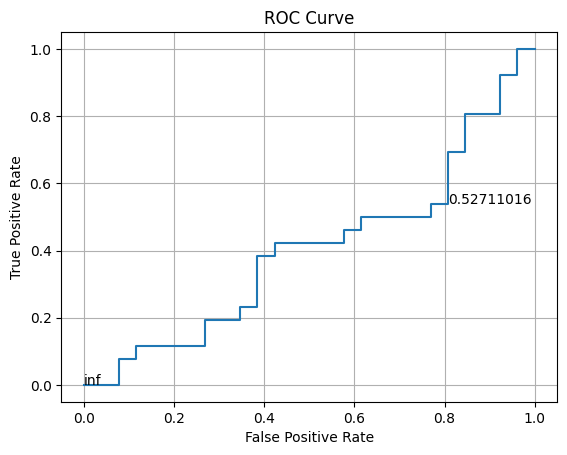

In [54]:
plt.plot(fp , tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.grid()
plt.title("ROC Curve")

skip = 20
for i in range(0 , len(thresholds) , skip):
    plt.text(fp[i] , tp[i] , thresholds[i])
plt.show()  


# Improving Model Performance

**TENSORFLOW CALLBACKS**

In [55]:
class LossCallback(Callback):
    def on_epoch_end(self , epoch , logs):
        print("\n For Epoch Number {} the model has a loss of {}".format(epoch + 1 , logs["loss"]))
        
    def on_batch_end(self , batch , logs):
        print("\n For Batch Number {} the model has a loss of {}".format(batch + 1 , logs["loss"])) 

In [56]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01) , loss = "binary_crossentropy" ,
                        metrics = metrics)

In [57]:
#history  = lenet_model.fit(train_dataset , validation_data = val_dataset , epochs = 1 , verbose = 1 , callbacks = [LossCallback()])

**CSVLOGGER**

In [58]:
csv_callback = CSVLogger("malaria_training_log.csv" , append = True , separator = ",")

In [59]:
metrics = [TruePositives(name = "TP") ,
           TrueNegatives(name = "TN") , FalsePositives(name = "FP") , 
           FalseNegatives(name = "FN") , Precision(name = "Precision") ,
           Recall(name = "Recall") , AUC(name = "AUC") , BinaryAccuracy(name = "Accuracy")]

In [60]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01) , loss = "binary_crossentropy" ,
                        metrics = metrics)

In [61]:
#history = lenet_model.fit(train_dataset , validation_data = val_dataset , epochs = 1 , verbose = 1 , callbacks = [csv_callback])

In [62]:
for images, labels in train_dataset.take(1):
    print(images.shape)

(32, 224, 224, 3)


In [63]:
# plt.plot(history.history["Accuracy"])
# plt.plot(history.history["val_Accuracy"])
# plt.title("Model Accuracy")
# plt.ylabel("accuracy")
# plt.xlabel("epoch")
# plt.legend(["train_accuracy" , "val_accuracy"])

**EarlyStopping**

In [64]:
es_callback = EarlyStopping(monitor = "val_loss" , patience = 3 , restore_best_weights = True , 
                            min_delta = 0 , verbose = 1 , mode= "auto" , baseline = None)

In [65]:
metrics = [TruePositives(name = "TP") ,
           TrueNegatives(name = "TN") , FalsePositives(name = "FP") ,  
              FalseNegatives(name = "FN") , Precision(name = "Precision") ,
              Recall(name = "Recall") , AUC(name = "AUC") , BinaryAccuracy(name = "Accuracy")]

In [66]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01) , loss = "binary_crossentropy" ,
                        metrics = metrics)

In [67]:
#history = lenet_model.fit(train_dataset , validation_data = val_dataset , epochs = 1 , verbose = 1,callbacks = [ csv_callback , es_callback]) 

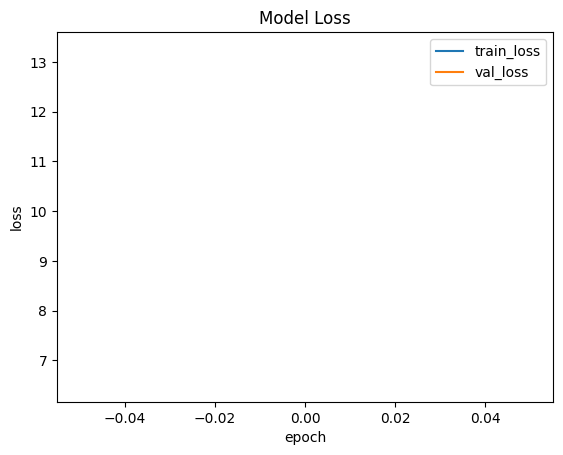

In [68]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"]) 
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss" , "val_loss"])

**LEARNING RATE SCHEDULING**

In [69]:
def scheduler(epoch , lr):
    if epoch <= 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    with train_writer.as_default():
        tf.summary.scalar("LearningRate")

scheduler_callback = LearningRateScheduler(scheduler , verbose = 1) 

In [70]:
metrics = [TruePositives(name = "TP") ,
           TrueNegatives(name = "TN") , FalsePositives(name = "FP") ,
              FalseNegatives(name = "FN") , Precision(name = "Precision") ,
                Recall(name = "Recall") , AUC(name = "AUC") , BinaryAccuracy(name = "Accuracy")]
lenet_model.compile(optimizer = Adam(learning_rate = 0.01) , loss = "binary_crossentropy" ,
                        metrics = metrics)

In [71]:
#lenet_model.fit(train_dataset , validation_data = val_dataset , epochs = 1 , verbose = 1,callbacks = [ es_callback , scheduler_callback])

In [72]:
# plt.plot(history.history["Accuracy"])
# plt.plot(history.history["val_Accuracy"])   
# plt.title("Model Accuracy")
# plt.ylabel("accuracy")
# plt.xlabel("epoch")
# plt.legend(["train_accuracy" , "val_accuracy"])

**MODEL CHECKPOINTING**

In [73]:
checkpoint_callback = ModelCheckpoint(filepath="malaria_model.keras" , monitor = "val_loss" , verbose = 1 ,
                                       save_best_only = True , mode = "auto" , save_weights_only = False , 
                                       save_freq = "epoch")

In [74]:
metrics = [TruePositives(name = "TP") ,
           TrueNegatives(name = "TN") , FalsePositives(name = "FP") ,       
              FalseNegatives(name = "FN") , Precision(name = "Precision") ,
                Recall(name = "Recall") , AUC(name = "AUC") , BinaryAccuracy(name = "Accuracy")]    

In [75]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01) , loss = "binary_crossentropy" ,
                        metrics = metrics)

In [76]:
#lenet_model.fit(train_dataset , validation_data = val_dataset , epochs = 1 , verbose = 1,callbacks = [checkpoint_callback])

**ReduceLearningRateOnPlateau**

In [77]:
plateau_callback = ReduceLROnPlateau(monitor = "val_loss" , factor = 0.1 , patience = 3 , 
                                  verbose = 1 , mode = "auto" , min_delta = 0.0001 , cooldown = 0,
                                  min_lr = 0.00001)

In [78]:
metrics = [TruePositives(name = "TP") ,
           TrueNegatives(name = "TN") , FalsePositives(name = "FP") ,   
                FalseNegatives(name = "FN") , Precision(name = "Precision") ,
                Recall(name = "Recall") , AUC(name = "AUC") , BinaryAccuracy(name = "Accuracy")]

In [79]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01) , loss = "binary_crossentropy" ,
                        metrics = metrics)

In [80]:
#lenet_model.fit(train_dataset , validation_data = val_dataset , epochs = 1 , verbose = 1,callbacks = [plateau_callback])

# TENSORBOARD INTEGRATION

**DATA LOGGING**

In [81]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = "./logs")

In [82]:
history = lenet_model.fit(train_dataset , validation_data= val_dataset , epochs = 1 , verbose = 1 , callbacks=[tensorboard_callback ])

414/414 ━━━━━━━━━━━━━━━━━━━━ 462s 1s/step - AUC: 0.6714 - Accuracy: 0.6281 - FN: 1091.8024 - FP: 1266.5470 - Precision: 0.6231 - Recall: 0.6766 - TN: 2050.5566 - TP: 2246.9204 - loss: 6.6286 - val_AUC: 0.6028 - val_Accuracy: 0.4882 - val_FN: 0.0000e+00 - val_FP: 846.0000 - val_Precision: 0.4882 - val_Recall: 1.0000 - val_TN: 0.0000e+00 - val_TP: 807.0000 - val_loss: 2.5956


In [83]:
METRIC_DIR = './logs/metrics'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [84]:
import datetime

LOG_DIR = './logs' 
print(LOG_DIR)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = LOG_DIR)

./logs


In [85]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=./logs --port=6012

In [87]:
def scheduler(epoch , lr):
    
    if epoch <= 1:
        learning_rate = lr
    else:
        learning_rate = lr.tf.math.exp(-0.1)
        learning_rate = learning_rate.numpy()
    
    with train_writer.as_default():
        tf.summary.scalar("Learning Rate" , data = learning_rate , stop = epoch)
    return learning_rate

scheduler_callback = LearningRateScheduler(scheduler , verbose = 1) 

C:\Users\asus\AppData\Local\Temp\ipykernel_19100\3441173637.py:6: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend('"train_loss' , "val_loss")


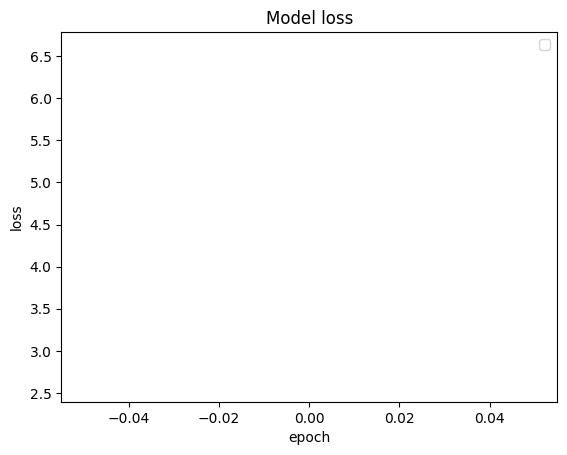

In [88]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend('"train_loss' , "val_loss")
plt.show()

In [89]:
# plt.plot(history.history["accuracy"])
# plt.plot(history.history["val_accuracy"])
# plt.title("Model Accuracy")
# plt.ylabel("Accuracy")
# plt.xlabel("Epoch")
# plt.legend('"train_accuracy' , "val_accuracy")
# plt.show()

In [90]:
# !rm -rf ./logs/     to remove tensorboard information

**HYPERPARAMETER TUNING**

In [91]:
# SEQUENTIAL MODEL
IM_SIZE = 224


def model_tune(hparams):
       lenet_model = tf.keras.Sequential([
                            InputLayer(input_shape = (IM_SIZE , IM_SIZE , 3)),
                            
                            Conv2D(filters = 6 , kernel_size = 3 , strides = 1 , padding = "valid" , 
                                   kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE]) , activation = "relu"),
                            BatchNormalization(),
                            MaxPool2D(pool_size= 2 , strides = 2),
                            Dropout(rate = hparams[HP_DROPOUT]),
                            
                            Conv2D(filters = 16 , kernel_size = 3 , strides = 1 , padding = "valid" , 
                                   kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE]) , activation = "relu"),                                                      
                            BatchNormalization(),
                            MaxPool2D(pool_size= 2 , strides = 2),
                            
                            Flatten(),
                            
                            Dense(hparams[HP_NUM_UNITS_1] , activation = "relu" , kernel_regularizer= L2(hparams[HP_REGULARIZATION_RATE])),
                            BatchNormalization(),
                            Dropout(rate = hparams[HP_DROPOUT]),
                            
                            Dense(hparams[HP_NUM_UNITS_2] , activation = "relu" , kernel_regularizer= L2(hparams[HP_REGULARIZATION_RATE])),
                            BatchNormalization(),

                            Dense(1 , activation = "sigmoid"),
       ])
       lenet_model.summary()
       

       lenet_model.compile(
              optimizer = Adam(learning_rate = hparams[HP_LEARNING_RATE]) , loss="binary_crossentropy" , metrics = ["accuracy"]
       )



       lenet_model.fit(val_dataset , epochs = 1)
       _ , accuracy = lenet_model.evaluate(val_dataset)
       return accuracy

In [92]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1' , hp.Discrete([16,32,64,128]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2' , hp.Discrete([16,32,64,128]))
HP_DROPOUT = hp.HParam('dropout_rate' , hp.Discrete([0.1 , 0.2 , 0.3]))
HP_REGULARIZATION_RATE = hp.HParam('regularization_rate' , hp.Discrete([0.001 , 0.01, 0.1]))
HP_LEARNING_RATE = hp.HParam('learning_rate' , hp.Discrete([1e-4 , 1e-3]))

In [93]:
run_number = 0
max_runs = 1

for num_units_1 in HP_NUM_UNITS_1.domain.values:
    for num_units_2 in HP_NUM_UNITS_2.domain.values:
        for dropout_rate in HP_DROPOUT.domain.values:
            for regularization_rate in HP_REGULARIZATION_RATE.domain.values:
                for learning_rate in HP_LEARNING_RATE.domain.values:
                    if run_number>= max_runs:
                        break
                    
                    hparams = {
                        HP_NUM_UNITS_1: num_units_1,
                        HP_NUM_UNITS_2: num_units_2,
                        HP_DROPOUT: dropout_rate,
                        HP_REGULARIZATION_RATE: regularization_rate,
                        HP_LEARNING_RATE: learning_rate, 
                    }
                    
                    file_writer = tf.summary.create_file_writer('logs/' + str(run_number))
                        
                    with file_writer.as_default():
                        hp.hparams(hparams)
                        accuracy = model_tune(hparams)
                        tf.summary.scalar('accuracy' , accuracy , step = 0)
                    print("For the run {} , hparams num_umits_1:{} , dropout:{} , regularization_rate:{} , learning_rate:{}", hparams[HP_LEARNING_RATE],
                          hparams[HP_DROPOUT] , hparams[HP_NUM_UNITS_1] , hparams[HP_NUM_UNITS_2] , hparams[HP_REGULARIZATION_RATE])
                
                    run_number += 1

c:\Users\asus\Documents\dl_cv_tensorflow\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │       746,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 748,065 (2.85 MB)

 Trainable params: 747,957 (2.85 MB)

 Non-trainable params: 108 (432.00 B)

52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 432ms/step - accuracy: 0.5881 - loss: 0.8700
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.5269 - loss: 0.7429
For the run {} , hparams num_umits_1:{} , dropout:{} , regularization_rate:{} , learning_rate:{} 0.0001 0.1 16 16 0.001


# DATA AUGMENTATION

In [94]:
def visualize(original , augmented):
    plt.subplot(1,2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(augmented)
    plt.title("Augmented Image")
    plt.axis("off")

In [95]:
original_image  , label_image = next(iter(train_dataset))
original_image = original_image[3]

In [96]:
augmented_image = tf.image.flip_left_right(original_image)
augmented_image = tf.image.random_flip_left_right(original_image)
augmented_image = tf.image.rot90(original_image)
augmented_image = tf.image.adjust_brightness(original_image , delta = 0.1)
augmented_image = tf.image.random_saturation(original_image , lower= 0, upper = 1.5)
augmented_image = tf.image.central_crop(original_image , central_fraction = 0.8)
augmented_image = tf.image.adjust_saturation(original_image , saturation_factor = 0.1)

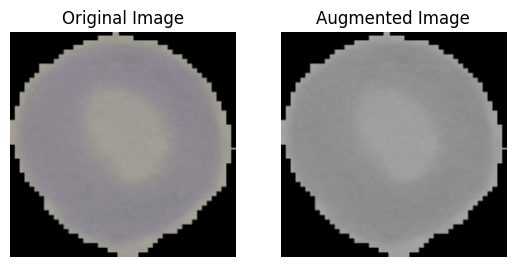

In [97]:
visualize(original_image, augmented_image)

In [98]:
# def resize_rescale(image , label):
#     #tf.print("Resize Rescale got shapes:", tf.shape(image))
#     #image , labels = inputs
#     image = tf.image.resize(image , (IM_SIZE , IM_SIZE))
#     image = tf.cast(image , tf.float32)/255.0
#    # image  = image[0][0]
#     return image , label

In [99]:
### tf.image augment

def augment(image , label):
    
    image , label = resize_rescale(image , label)
    
    image = tf.image.rot90(image)
    image = tf.image.flip_left_right(image)
    #image = tf.image.random_flip_left_right(image)
    image = tf.image.adjust_brightness(image , delta = 0.1)
    
    return image , label

In [100]:
class RotNinety(tf.keras.layers.Layer):
    
    def __init__(self):
        super().__init__()
    
    def call(self , image):
        return tf.image.rot90(image)

In [101]:
### tf.keras.layer augment
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast , Resizing
from tensorflow.keras.layers import Rescaling, RandomTranslation, RandomHeight, RandomWidth
augment_layers = tf.keras.Sequential([
    RandomFlip(mode = "horizontal"),
    #RandomRotation(factor = (0.25 , 0.2501))])
    RotNinety()
    ])

def augment_layer(image , label):
    image , label = resize_rescale(image , label)
    return augment_layers(image , training = True) , labels    


In [102]:
train_dataset = train_dataset.map(resize_rescale , num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(resize_rescale , num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resize_rescale , num_parallel_calls=tf.data.AUTOTUNE)
train_dataset
# val_dataset
# test_dataset

c:\Users\asus\Documents\dl_cv_tensorflow\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [103]:
for image, label in test_dataset.take(1):
    print(image.shape)

(32, 224, 224, 3)


In [104]:
#history = lenet_model.fit(train_dataset , validation_data = val_dataset , epochs = 1 , verbose = 1)
                          #,callbacks = [csv_callback, es_callback])

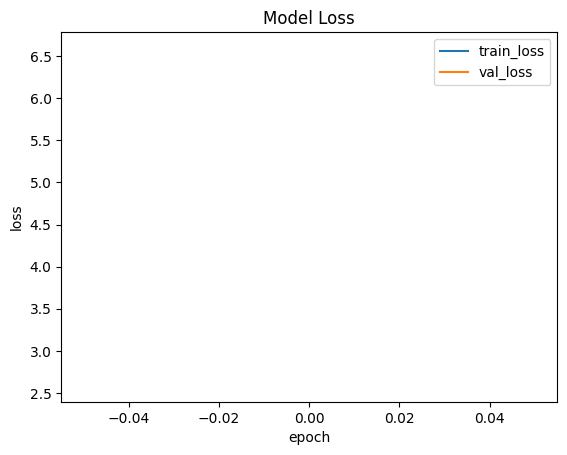

In [105]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss" , "val_loss"])
plt.show()

In [106]:
import cv2

In [107]:
for image,lavels in train_dataset.take(1):
    print(image.shape)
    # image = image[0]
    # cv2.imwrite("malaria_image.jpg", image.numpy() * 255)  # Save the image as a JPEG file
    # print("Image saved as malaria_image.jpg")
    

(32, 224, 224, 3)


In [108]:
image = cv2.imread("malaria_image.jpg")
print(image.shape)


(224, 224, 3)


In [109]:
image = tf.expand_dims(image , axis = 0)
print(image.shape)

(1, 224, 224, 3)


In [110]:
lenet_model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


array([[0.56566644]], dtype=float32)

<Figure size 100x100 with 0 Axes>

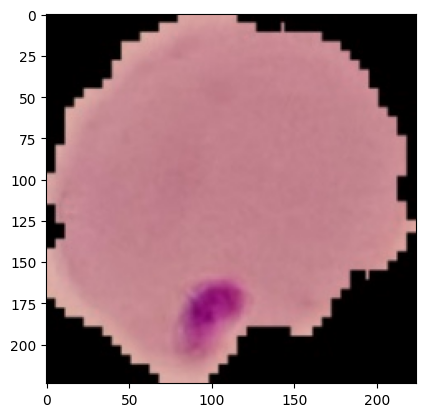

<Figure size 100x100 with 0 Axes>

In [111]:
plt.imshow(image[0])
plt.figure(figsize=(1,1))

**MIXUP DATA AUGMENTATION**

In [112]:
import tensorflow_probability as tfp

In [113]:
import cv2
import numpy as np

In [114]:
# === CONFIG ===
IMAGE_SIZE = 224
IMG_PATH_1 = "C:\\Users\\asus\\Downloads\\Datasets\\animals_cnn_classification\\dataset\\single_prediction\\cat_or_dog_1.jpg"
IMG_PATH_2 = "C:\\Users\\asus\\Downloads\\Datasets\\animals_cnn_classification\\dataset\\single_prediction\\cat_or_dog_2.jpg"

# === LOAD AND PREPROCESS ===
def load_image_cv(path):
    image = cv2.imread(path)                # BGR format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]
    return image

image_1 = load_image_cv(IMG_PATH_1)
image_2 = load_image_cv(IMG_PATH_2)

# Dummy one-hot labels (you can use actual class labels)
label_1 = np.array([1.0, 0.0], dtype=np.float32)
label_2 = np.array([0.0, 1.0], dtype=np.float32)

In [115]:
def mixup(image_label_1 , image_label_2):
    
    # IM_SIZE = 224
    # image_1 = cv2.resize(cv2.imread("image_.jpg") , (IM_SIZE , IM_SIZE))
    # image_2 = cv2.resize(cv2.imread("image_2.jpg") , (IM_SIZE , IM_SIZE))
    # print(image_1.shape, image_2.shape)

    image_1 , label_1 = image_label_1
    image_2 , label_2 = image_label_2
    
    lamda = tfp.distributions.Beta(0.4, 0.4).sample()
    
    mixed_image = lamda * tf.cast(image_1 , tf.float32) + (1 - lamda) * tf.cast(image_2 , tf.float32)
    mixed_label = lamda * tf.cast(label_1 , tf.float32) + (1 - lamda) * tf.cast(label_2 , tf.float32)   
    
    return mixed_image , mixed_label

In [116]:
# train_dataset is original dataset of (image, label) pairs
train_dataset_1 = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True)
train_dataset_2 = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True)


# now apply to zipped datasets
mixed_dataset = tf.data.Dataset.zip((train_dataset_1 , train_dataset_2))

#now apply to each pair of images
train_dataset = mixed_dataset.map(mixup).prefetch(tf.data.AUTOTUNE)

c:\Users\asus\Documents\dl_cv_tensorflow\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


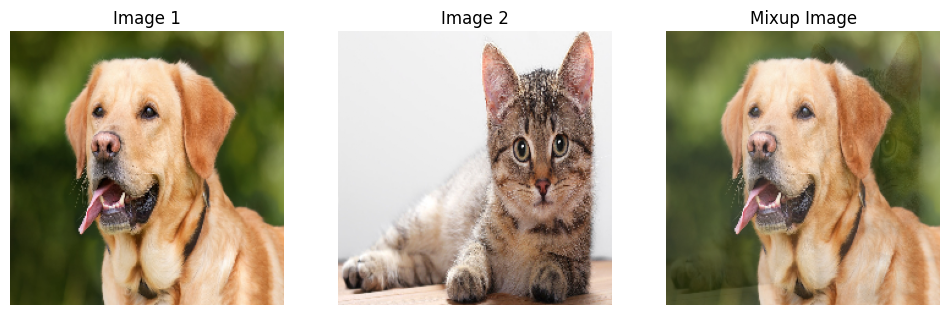

In [117]:
#for (img1, lbl1), (img2, lbl2) in mixed_dataset.take(1):
#mixed_img, mixed_lbl = mixup((img_1, lbl_1), (img_2, lbl_2))


mixed_img, mixed_lbl = mixup((image_1, label_1), (image_2, label_2))
 
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
#plt.imshow(image_1)  # scale if needed
plt.imshow(image_1)  # scale if needed
plt.title("Image 1")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(image_2)  # scale if needed
plt.title("Image 2")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(mixed_img.numpy())  # scale if needed
plt.title("Mixup Image")
plt.axis("off")
plt.show()


In [118]:
# for (img1, lbl1), (img2, lbl2) in mixed_dataset.take(1):
    
#     mixed_img, mixed_lbl = mixup((img_1, lbl_1), (img_2, lbl_2))
    
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 3, 1)
#     plt.imshow(img_1) 
#     plt.title("Image 1")
#     plt.axis("off")
    
    
#     plt.subplot(1, 3, 2)
#     plt.imshow(img_2) 
#     plt.title("Image 2")
#     plt.axis("off")
    
#     plt.subplot(1, 3, 3)
#     plt.imshow(mixed_img.numpy())
#     plt.title("Mixup Image")
#     plt.axis("off")
#     plt.show()


In [119]:
for image, label in train_dataset.take(1):
    print(image.shape)

(32, 224, 224, 3)


In [120]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [121]:
val_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

**CUTMX AUGMENTATION**

In [122]:
import cv2

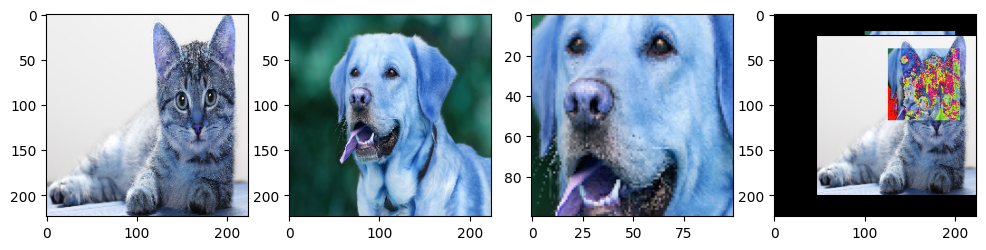

In [123]:
plt.figure(figsize=(12, 4))
plt.subplot(1 , 4 , 1)
image_1 = cv2.resize(cv2.imread("cat.jpg") , (IM_SIZE , IM_SIZE))
plt.imshow(image_1)

plt.subplot(1 , 4 , 2)
image_2 = cv2.resize(cv2.imread("dog.jpg") , (IM_SIZE , IM_SIZE))
plt.imshow(image_2)

plt.subplot(1, 4 , 3)
crop = tf.image.crop_to_bounding_box(image_2 , offset_height=50, offset_width=50, target_height=100, target_width=100)
plt.imshow(crop)

plt.subplot(1,4,4)
image_4 = tf.image.pad_to_bounding_box(crop ,20 , 100 , IM_SIZE , IM_SIZE)
plt.imshow(image_4)

plt.subplot(1, 5, 5)
image_5 = tf.image.pad_to_bounding_box(crop , 10 , 100 , IM_SIZE , IM_SIZE)
plt.imshow(image_4 + image_1)

**AUGMENTATION AND ALBUMENTATION**

In [124]:
import albumentations as A
#from albumentations.augmentations.dropout import Cutout

In [125]:
IM_SIZE = 224
transforms = A.Compose([
        A.Resize(IM_SIZE, IM_SIZE),
        A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip(),] , p = 0.3), 
        A.RandomRotate90(p=0.5),
        
        A.RandomBrightnessContrast(p=0.5 , brightness_limit=0.2, contrast_limit=0.2 , 
                                always_apply = False ),
        A.CoarseDropout(max_h_size=8 ,  max_w_size=8, num_holes=8, fill_value=0, p=0.5 , always_apply = False),
        
])


C:\Users\asus\AppData\Local\Temp\ipykernel_19100\1869644329.py:9: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomBrightnessContrast
  A.RandomBrightnessContrast(p=0.5 , brightness_limit=0.2, contrast_limit=0.2 ,
C:\Users\asus\AppData\Local\Temp\ipykernel_19100\1869644329.py:11: UserWarning: Argument(s) 'max_h_size, max_w_size, num_holes, fill_value, always_apply' are not valid for transform CoarseDropout
  A.CoarseDropout(max_h_size=8 ,  max_w_size=8, num_holes=8, fill_value=0, p=0.5 , always_apply = False),


In [126]:
# def aug_albument(image , label):
#     image = image.numpy() 
#     label = label.numpy()
#     # apply albumentations transforms
    
#     augmented = transforms(image = image)["image"]
    
#     return augmented.astype(np.float32) , label.astype(np.float32)

In [127]:
# def process_data(image , label):
#     aug_img = tf.numpy_function(func = aug_albument , inp = [image , label] , Tout = [tf.float32 , tf.float32])
#     #aug_img.set_shape([IM_SIZE , IM_SIZE , 3])
#     return aug_img , label

In [128]:
#train_dataset = train_dataset.map(process_data , num_parallel_calls=tf.data.AUTOTUNE)

In [129]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [130]:
# im , _ = next(iter(train_dataset.take(1)))
# plt.imshow(im.numpy())

In [131]:
# plt.figure(figsize=(8, 8))

# for i in range(1 , 32):
#     plt.subplot(8 , 4 , i)
#     plt.imshow(im[i])

# Advanced Tensorflow 

**CUSTOM LOSS AND METRICS**

In [132]:
metrics = [TruePositives(name = "TP") ,
           TrueNegatives(name = "TN") , FalsePositives(name = "FP") ,
                FalseNegatives(name = "FN") , Precision(name = "Precision") ,
                    Recall(name = "Recall") , AUC(name = "AUC") , BinaryAccuracy(name = "Accuracy")]    

In [133]:
FACTOR = 1.0
def custom_bce(FACTOR):
    def loss(y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred) * FACTOR
    return loss


In [134]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01) , loss = custom_bce(FACTOR),
                        metrics = metrics , )

In [135]:
# history = lenet_model.fit(train_dataset , validation_data = val_dataset , epochs = 1 , verbose = 1)

**CUSTOM LOSS CLASS**

In [136]:
FACTOR = 1
class CustomBCE(tf.keras.losses.Loss):
    def __init__(self , FACTOR):
        super(CustomBCE , self).__init__()
        self.FACTOR  = FACTOR
    def call(self , y_true , y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred) * self.FACTOR
        

In [137]:
# Custom loss method with parameters
def custom_bce(FACTOR):
    def loss(y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred) * FACTOR
    def metric(y_true , y_pred):
        binary_accuracy = BinaryAccuracy()
        return binary_accuracy(y_true , y_pred)*FACTOR
    return loss


In [138]:
# Custom loss method without parameters
def custom_bce(y_true , y_pred):
    bcs = BinaryCrossentropy()
    return bce(y_true, y_pred)

In [ ]:
# lenet_model.compile(optimizer = Adam(learning_rate = 0.01) , loss = CustomBCE(FACTOR) ,
                        # metrics = [custom_accuracy] , )

In [ ]:
# history = lenet_model.fit(train_dataset , validation_data = val_dataset , epochs = 1 , verbose = 1) 

In [140]:
# Custom Metric Method(without parameters)

def custom_accuracy(y_true , y_pred):
    binary_accuracy = BinaryAccuracy()
    bce = BinaryCrossentropy()
    tf.keras.metrics.binary_accuracy(
        y_true , y_pred , threshold = 0.5
    )
    return binary_accuracy(y_true , y_pred)


In [141]:
lenet_model.compile(optimizer= Adam(learning_rate =  0.01) , loss = CustomBCE(FACTOR) , metrics = [custom_accuracy])

In [142]:
# history = lenet_model.fit(train_dataset , validation_data = val_dataset , epochs = 1 , verbose = 1) 